In [12]:
%matplotlib inline
import sys
sys.path.append("/home/diego/Dropbox/hold_noise/iclamp-glm/")

import matplotlib.pyplot as plt
import numpy as np

from icglm.models.lssrm import LSSRM
from icglm.kernels.rect import KernelRect
from icglm.processes import OUProcess, GeneralCov

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Define stimulus process, GLM and sample a spike train

In [13]:
t = np.arange(0, 2000, 1)
mu, sd = 30, 25
ou = OUProcess(mu=mu, sd=sd, tau=3)
stim = ou.sample(t, seed=0, shape=(1,))
stim = np.concatenate([stim] * 25, 1)

vr = -62
kappa = KernelRect.exponential(tf=290, dt=8, tau=40, A=1e-2)
eta = KernelRect.exponential(tf=450, dt=25, tau=75, A=3)
gamma = KernelRect.exponential(tf=225, dt=25, tau=25, A=5)
vt, dv = -46, 1
lssrm = LSSRM(vr=vr, kappa=kappa, eta=eta, vt=vt, dv=dv, gamma=gamma, lam=np.inf)

np.random.seed(0)
v, u, r, mask_spk_true = lssrm.sample(t, stim)

# fig, (ax1, ax2)plt.figure()


### Decode stimulus

Starting gradient ascent... 

 Iteration 10 of 30 | Elapsed time: 3.29 seconds | log_prior=-56.6 | log_posterior=-1804.9
 
 Iteration 10 of 30 | Converged | Elapsed time: 0.0548 minutes | Log posterior is monotonic 



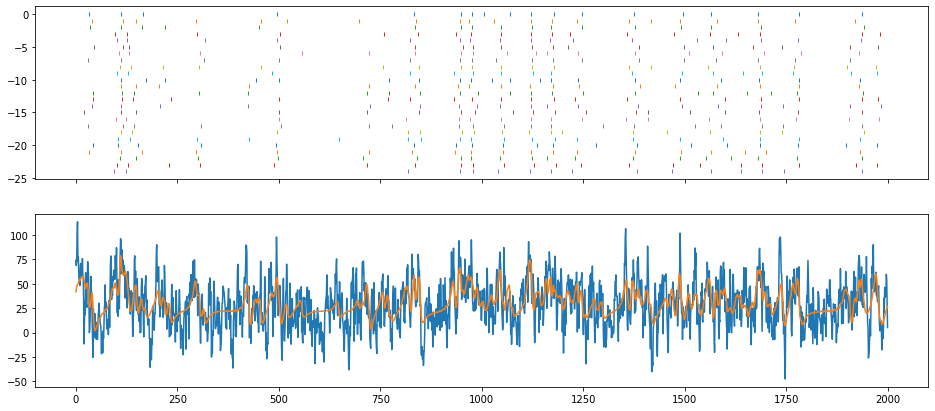

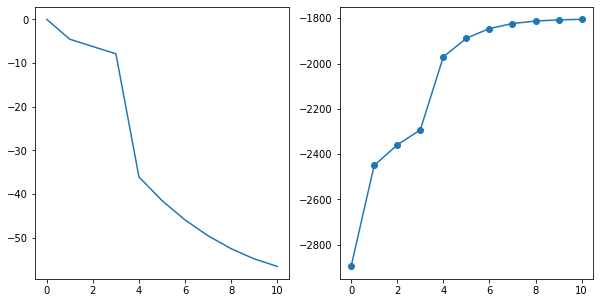

In [18]:
newton_kwargs = dict(max_iterations=30, stop_cond=5e-6, learning_rate=5e-1, initial_learning_rate=5e-2, warm_up_iterations=3)
stim0 = np.zeros(len(t)) + mu
stim_dec, optimizer = lssrm.decode_stim_from_spikes(t, mask_spk_true, stim0=stim0, prior=ou, 
                                                    newton_kwargs=newton_kwargs, verbose=True)

fig, (ax1, ax2) = plt.subplots(figsize=(16, 7), nrows=2, sharex=True)
for sw in range(mask_spk_true.shape[1]):
    _mask = mask_spk_true[:, sw]
    ax1.plot(t[_mask], np.zeros(np.sum(_mask)) - sw, '|', ms=4)
ax2.plot(t, np.mean(stim, 1))
ax2.plot(t, stim_dec)

fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)
ax1.plot(optimizer.log_prior_iterations)
ax2.plot(optimizer.log_posterior_iterations, '-o')

Starting gradient ascent... 

 Iteration 10 of 30 | Elapsed time: 2.57 seconds | log_prior=-62.55 | log_posterior=-1830.75
 
 Iteration 10 of 30 | Converged | Elapsed time: 0.0428 minutes | Log posterior is monotonic 



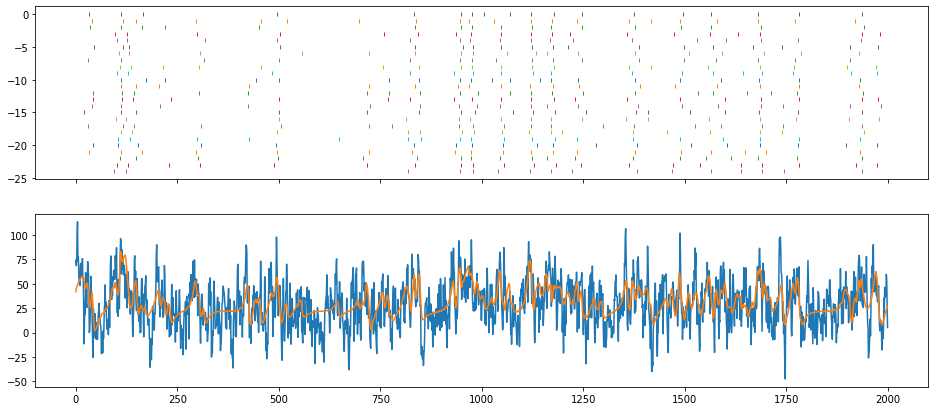

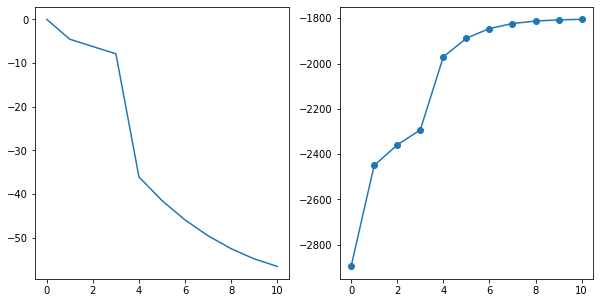

In [19]:
from icglm.models.glm import GLM

kappa = lssrm.kappa.copy()
kappa.coefs = kappa.coefs / lssrm.dv
# eta = eta.copy()
eta = KernelRect(eta.tbins, coefs=(eta.coefs + gamma.interpolate(eta.tbins[:-1])) / lssrm.dv)
glm = GLM(kappa=kappa, eta=eta, u0=-(lssrm.vr - lssrm.vt) / lssrm.dv)

stim_dec2, optimizer2 = glm.decode(t, mask_spk_true, stim0=stim0, prior=ou, 
                                  newton_kwargs=newton_kwargs, verbose=True)

fig, (ax1, ax2) = plt.subplots(figsize=(16, 7), nrows=2, sharex=True)
for sw in range(mask_spk_true.shape[1]):
    _mask = mask_spk_true[:, sw]
    ax1.plot(t[_mask], np.zeros(np.sum(_mask)) - sw, '|', ms=4)
ax2.plot(t, np.mean(stim, 1))
ax2.plot(t, stim_dec2)

fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)
ax1.plot(optimizer.log_prior_iterations)
ax2.plot(optimizer.log_posterior_iterations, '-o')

In [17]:
print(np.allclose(stim_dec, stim_dec2))
print(np.all(np.abs(stim_dec - stim_dec2) < 1e-1))
print(np.where(np.abs(stim_dec - stim_dec2) > 1e-5))

True
True
(array([], dtype=int64),)


In [21]:
from scipy.linalg import cholesky_banded
from icglm.metrics.decoding import log_det_from_banded_cholesky

h_log_posterior_banded = optimizer.h_log_posterior
inv_cov_banded_cholesky = cholesky_banded(-h_log_posterior_banded, lower=True)
cov_log_determinant = -log_det_from_banded_cholesky(inv_cov_banded_cholesky)

h_log_posterior_banded = optimizer2.h_log_posterior
inv_cov_banded_cholesky = cholesky_banded(-h_log_posterior_banded, lower=True)
cov_log_determinant2 = -log_det_from_banded_cholesky(inv_cov_banded_cholesky)

print(cov_log_determinant, cov_log_determinant2)

11093.022273350745 11096.128942860723


In [5]:
newton_kwargs = dict(max_iterations=30, stop_cond=5e-6, learning_rate=5e-1, initial_learning_rate=5e-2, warm_up_iterations=3)

stim0 = np.zeros(len(t)) + mu

self = lssrm

# u0_glm = (self.vt - self.vr) / self.dv
# kappa_glm = KernelRect(self.kappa.tbins, self.kappa.coefs / self.dv)
# tbins = np.sort(np.array(list(set(self.eta.tbins) | set(self.gamma.tbins))))
# coefs = self.eta.interpolate(tbins[:-1]) + self.gamma.interpolate(tbins[:-1])
# eta_glm = KernelRect(tbins, coefs / self.dv)
# glm = GLM(u0=u0_glm, kappa=kappa_glm, eta=eta_glm)
# stim_dec, optimizer = glm.decode(t, mask_spk_true, stim0=stim0, prior=ou, newton_kwargs=newton_kwargs, verbose=True)

# v0 = np.zeros(len(t)) + mu * self.kappa.area() + self.vr
newton_kwargs = dict(max_iterations=30, stop_cond=5e-4, learning_rate=1e-1, initial_learning_rate=1e-2, warm_up_iterations=3)
v0 = np.zeros(len(t)) + self.vr
vou = OUProcess(mu=self.vr, sd=30, tau=30)
vglm = GLM(u0=self.vt / self.dv, kappa=KernelRect([0, 1], [1 / self.dv]), eta=self.gamma.copy())
v_dec = []
for sw in range(mask_spk_true.shape[1]):
    verbose = True if sw == 0 else False
    _v_dec, _optimizer = vglm.decode(t, mask_spk_true[:, sw:sw+1], stim0=v0, prior=vou, newton_kwargs=newton_kwargs, verbose=verbose)
    v_dec += [_v_dec]
v_dec = np.stack(v_dec, 1)

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(16, 7), nrows=3, sharex=True)
for sw in range(mask_spk_true.shape[1]):
    _mask = mask_spk_true[:, sw]
    ax1.plot(t[_mask], np.zeros(np.sum(_mask)) - sw, '|', ms=4)
ax2.plot(t, v[:, 0])
ax2.plot(t, v_dec[:, 0], '--')
ax2.plot(t, v[:, 1])
ax2.plot(t, v_dec[:, 1], '--')
ax3.plot(t, np.mean(stim, 1))
ax3.plot(t, stim_dec)

fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)
ax1.plot(optimizer.log_prior_iterations)
ax2.plot(optimizer.log_posterior_iterations, '-o')

NameError: name 'GLM' is not defined

#### decode voltage

In [156]:
# estimate voltage prior
t = np.arange(0, 2000, 1)
mu, sd = 30, 25
ou = OUProcess(mu=mu, sd=sd, tau=3)
stim = ou.sample(t, seed=0, shape=(500,))
v, r, mask_spk_true = lssrm.sample(t, stim)
mu, cov = np.mean(v, 1), np.cov(v)

newton_kwargs = dict(max_iterations=30, stop_cond=5e-6, learning_rate=5e-1, initial_learning_rate=5e-2, warm_up_iterations=3)

v0 = np.zeros(len(t)) + mu

prior = GeneralCov(mu=mu, cov=cov)
prior.set_prior_on_t(t)

# newton_kwargs = dict(max_iterations=30, stop_cond=5e-4, learning_rate=1e-1, initial_learning_rate=1e-2, warm_up_iterations=3)
# v0 = np.zeros(len(t)) + self.vr
# vou = OUProcess(mu=self.vr, sd=30, tau=30)
# vglm = GLM(u0=self.vt / self.dv, kappa=KernelRect([0, 1], [1 / self.dv]), eta=self.gamma.copy())
# v_dec = []
# for sw in range(mask_spk_true.shape[1]):
#     verbose = True if sw == 0 else False
#     _v_dec, _optimizer = vglm.decode(t, mask_spk_true[:, sw:sw+1], stim0=v0, prior=vou, newton_kwargs=newton_kwargs, verbose=verbose)
#     v_dec += [_v_dec]
# v_dec = np.stack(v_dec, 1)

# fig, (ax1, ax2, ax3) = plt.subplots(figsize=(16, 7), nrows=3, sharex=True)
# for sw in range(mask_spk_true.shape[1]):
#     _mask = mask_spk_true[:, sw]
#     ax1.plot(t[_mask], np.zeros(np.sum(_mask)) - sw, '|', ms=4)
# ax2.plot(t, v[:, 0])
# ax2.plot(t, v_dec[:, 0], '--')
# ax2.plot(t, v[:, 1])
# ax2.plot(t, v_dec[:, 1], '--')
# ax3.plot(t, np.mean(stim, 1))
# ax3.plot(t, stim_dec)

# fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)
# ax1.plot(optimizer.log_prior_iterations)
# ax2.plot(optimizer.log_posterior_iterations, '-o')

LinAlgError: 2-th leading minor not positive definite

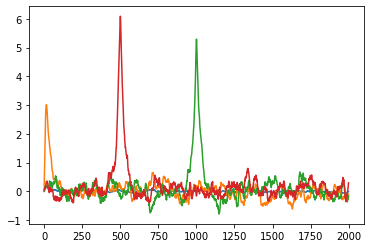

In [166]:
plt.figure()
plt.plot(cov[0, :])
plt.plot(cov[10, :])
plt.plot(cov[1000, :])
plt.plot(cov[500, :])

In [ ]:
band(cov)